In [201]:
# Importamos las librerias necesarias
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    print("MPS device no fue encontrado.")

tensor([1.], device='mps:0')


In [202]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

In [203]:
# Asignamos el dataset a la variable "housing"
df = fetch_california_housing(as_frame=True)
df = df.frame

In [204]:
# Vemos las primeras 5 filas para verificar que haya importado correctamente
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [205]:
# Extraemos los valores de los inputs (X) y el output (y)
X = df[["MedInc","HouseAge","AveRooms","AveBedrms","Population","AveOccup",'Latitude','Longitude']].values
y = df['MedHouseVal'].values

In [206]:
# Hacemos split aleatorio de los datos para obtener datos de entrenamiento (80%) y de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [207]:
# Estandarizamos X para obtener mayor eficiencia computacional
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [208]:
# Movemos los tensores para hacer entrenamiento en GPU (device)
X_train_tensor = torch.tensor(X_train, device=device, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, device=device, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, device=device, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, device=device, dtype=torch.float32).view(-1, 1)

In [209]:
# Definimos el modelo de aprendizaje profundo
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.selu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = torch.relu(self.fc2(x))
        x = self.bn2(x)

        x = torch.relu(self.fc3(x))
        x = self.bn3(x)

        x = self.fc4(x)
        return x

In [210]:
# Instanciamos el modelo, la función de pérdida y el optimizador 
model = Net()
model.to(device)

criterion = nn.MSELoss() # Utilizamos MSE para la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.0065)

In [211]:
# Hacemos el bucle de entrenamiento del modelo
epochs = 2400
torch.autograd.set_detect_anomaly(True)
plot_x = []
plot_y = []
for epoch in range(epochs):

    optimizer.zero_grad() # Reseteamos los gradientes a cero para que no se acumulen

    outputs = model(X_train_tensor) # Aplicamos el forward pass
    loss = criterion(outputs, y_train_tensor) # Comparamos las predicciones (outputs) con respecto a los reales (y_train_tensor) para calcular el costo

    loss.backward() # Utilizamos la regla de la cadena para calcular el costo del gradiente con respecto a los parametros
    optimizer.step() # Ajustamos parametros para reducir el costo

    plot_x.append(epoch+1)
    plot_y.append(loss.item())
    
    if (epoch+1) % 100 == 0:
        print(f'Epoca [{epoch+1}/{epochs}], Pérdida: {loss.item():.4f}')

Epoca [100/2400], Pérdida: 0.3101
Epoca [200/2400], Pérdida: 0.2797
Epoca [300/2400], Pérdida: 0.2371
Epoca [400/2400], Pérdida: 0.2528
Epoca [500/2400], Pérdida: 0.2411
Epoca [600/2400], Pérdida: 0.2376
Epoca [700/2400], Pérdida: 0.2348
Epoca [800/2400], Pérdida: 0.2255
Epoca [900/2400], Pérdida: 0.2188
Epoca [1000/2400], Pérdida: 0.2203
Epoca [1100/2400], Pérdida: 0.1856
Epoca [1200/2400], Pérdida: 0.2119
Epoca [1300/2400], Pérdida: 0.2069
Epoca [1400/2400], Pérdida: 0.2072
Epoca [1500/2400], Pérdida: 0.2074
Epoca [1600/2400], Pérdida: 0.1714
Epoca [1700/2400], Pérdida: 0.1985
Epoca [1800/2400], Pérdida: 0.2012
Epoca [1900/2400], Pérdida: 0.1990
Epoca [2000/2400], Pérdida: 0.1938
Epoca [2100/2400], Pérdida: 0.1945
Epoca [2200/2400], Pérdida: 0.1639
Epoca [2300/2400], Pérdida: 0.1923
Epoca [2400/2400], Pérdida: 0.1881


In [212]:
# Obtenemos MAE, MSE, y R2
with torch.no_grad():
    model.eval()
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor)
    MAE = mean_absolute_error(y_test_tensor.cpu() , predictions.cpu())
    R2  = r2_score(y_test_tensor.cpu() , predictions.cpu())
    print('MAE = ', MAE)
    print(f'MSE = {mse.item()}')
    print('R2 = ', R2)

MAE =  0.3323649
MSE = 0.25318217277526855
R2 =  0.8067914875442088


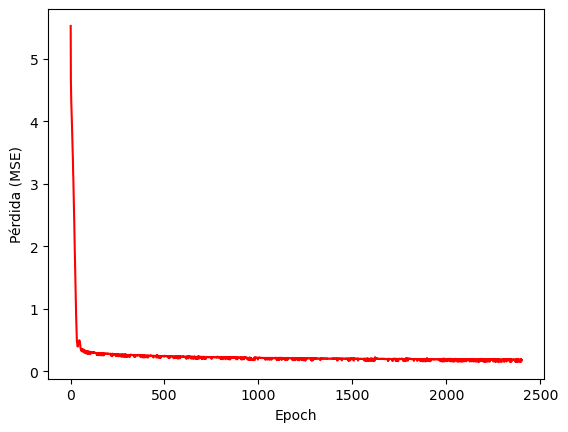

In [213]:
# Graficamos el comportamiento de la función de pérdida
plt.plot(plot_x, plot_y, color='red')
plt.xlabel('Epoch')
plt.ylabel('Pérdida (MSE)')
plt.show()

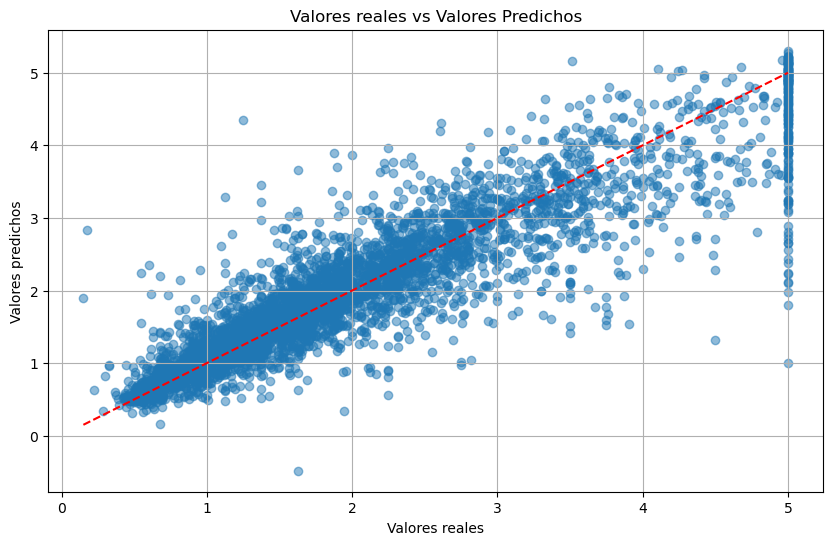

In [214]:
# Graficamos la diferencia entre los valores predichos y los reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor.cpu(), predictions.cpu(), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--') # Línea de predicciones "perfectas"
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Valores reales vs Valores Predichos')
plt.grid()
plt.show()